<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TS_SunspotForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv

--2020-09-29 06:53:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-29 06:53:47 (102 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [2]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("Sunspots.csv", index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


<Figure size 360x432 with 0 Axes>

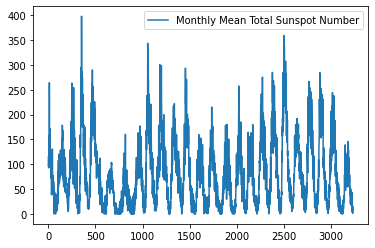

In [4]:
fig = plt.figure(figsize=(5, 6));
df.plot();

In [5]:
data = df["Monthly Mean Total Sunspot Number"]

### Multi-output forecasting w. single step model

Predict multiple next values at once.

In [6]:
BUFFER_SIZE = 2048
WINDOW_SIZE = 60

samples = tf.data.Dataset.from_tensor_slices(data)
samples = samples.window(size=WINDOW_SIZE + 1, shift=1, drop_remainder=True).flat_map(lambda w : w.batch(WINDOW_SIZE + 1))
samples = samples.map(lambda x : (tf.expand_dims(x[:-1], axis=-1), x[1:]))
samples = samples.shuffle(BUFFER_SIZE)

In [7]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int((1 - test_size) * num_samples)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_samples - num_train_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

Number of training samples: 2540
Number of validation samples: 635


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense

In [9]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

In [10]:
model.compile(optimizer="rmsprop", loss="huber", metrics=["mae", "mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            192       
_________________________________________________________________
lstm (LSTM)                  (None, 60, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
dense (Dense)                (None, 60, 32)            2080      
_________________________________________________________________
dense_1 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_2 (Dense)              (None, 60, 1)             17        
Total params: 134,657
Trainable params: 134,657
Non-trainable params: 0
__________________________________________________

In [11]:
model.fit(ds_train, epochs=200, validation_data=ds_val);

Epoch 1/200
40/40 [==============================] - 2s 38ms/step - loss: 74.8199 - mae: 75.3154 - mse: 10170.8545 - val_loss: 71.2641 - val_mae: 71.7585 - val_mse: 9594.6924
Epoch 2/200
40/40 [==============================] - 1s 21ms/step - loss: 64.1743 - mae: 64.6671 - mse: 8197.7725 - val_loss: 60.0629 - val_mae: 60.5551 - val_mse: 7442.7725
Epoch 3/200
40/40 [==============================] - 1s 21ms/step - loss: 52.9019 - mae: 53.3939 - mse: 6218.4321 - val_loss: 45.4100 - val_mae: 45.9013 - val_mse: 4952.1821
Epoch 4/200
40/40 [==============================] - 1s 21ms/step - loss: 40.4742 - mae: 40.9655 - mse: 4173.0151 - val_loss: 35.0134 - val_mae: 35.5013 - val_mse: 3330.5583
Epoch 5/200
40/40 [==============================] - 1s 21ms/step - loss: 31.3930 - mae: 31.8833 - mse: 2676.7424 - val_loss: 28.4517 - val_mae: 28.9410 - val_mse: 2205.3708
Epoch 6/200
40/40 [==============================] - 1s 21ms/step - loss: 24.4700 - mae: 24.9591 - mse: 1596.3245 - val_loss: 22.